So, here we will implement "Network in network" model by reading it's paper.

First of all, i want to talk about new ideas that this paper has brought to us. They are quite interesting and i was enjoying reading article.

### New ideas

**1. Use of Multilayer perceptron**

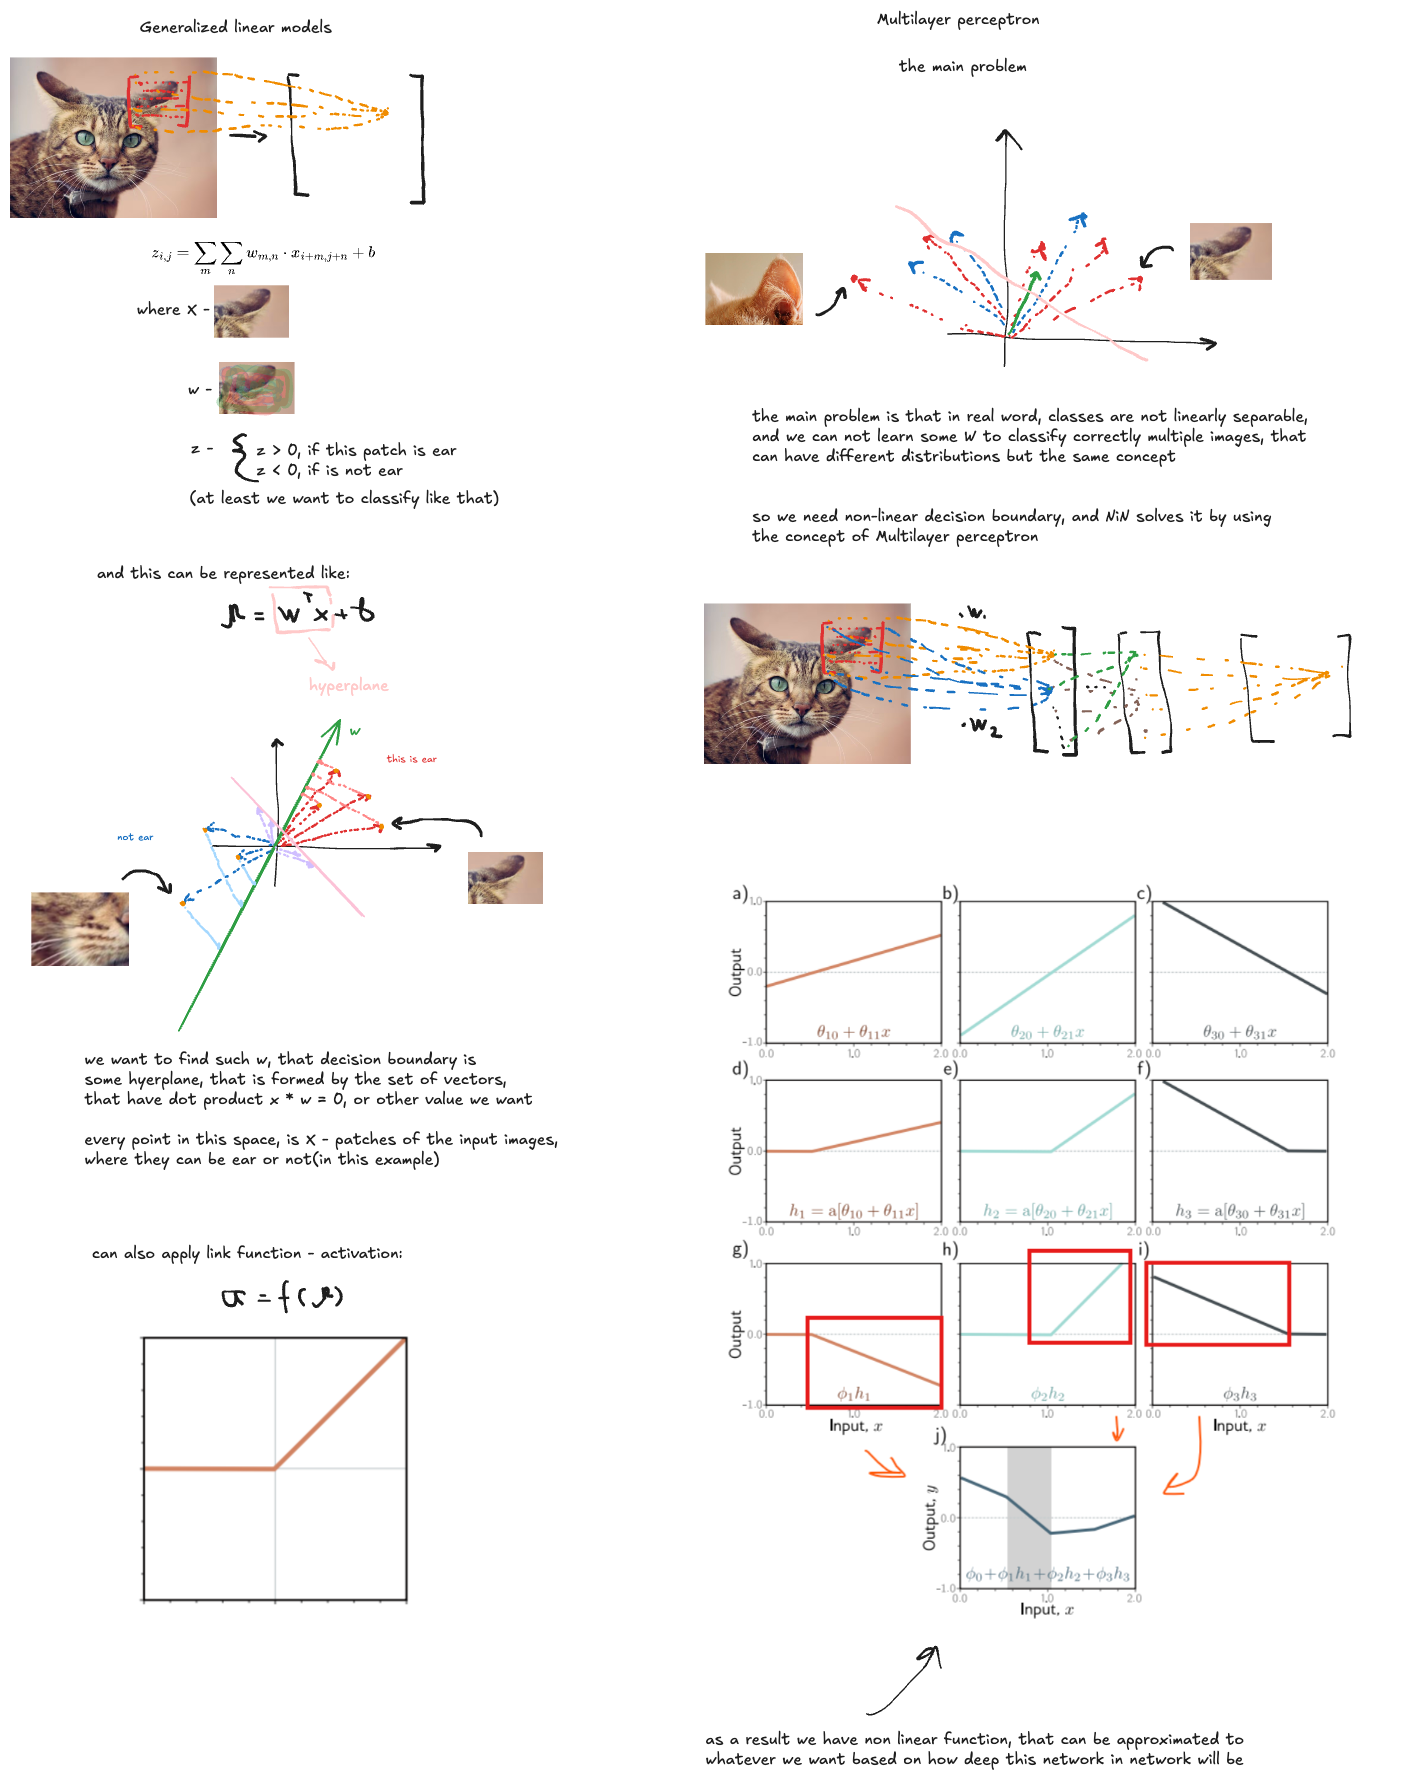

Above you can see my visualization and intuition about it, now i want to discuss it briefly. The main problem that convential CNN's have - is that they assume that data is linearly separable. So, if we take some filter(kernel) that was learnt to detect ears in a image of a cat - CNN tries to separete it by hyperplane since convolution is linear operation.

From paper:
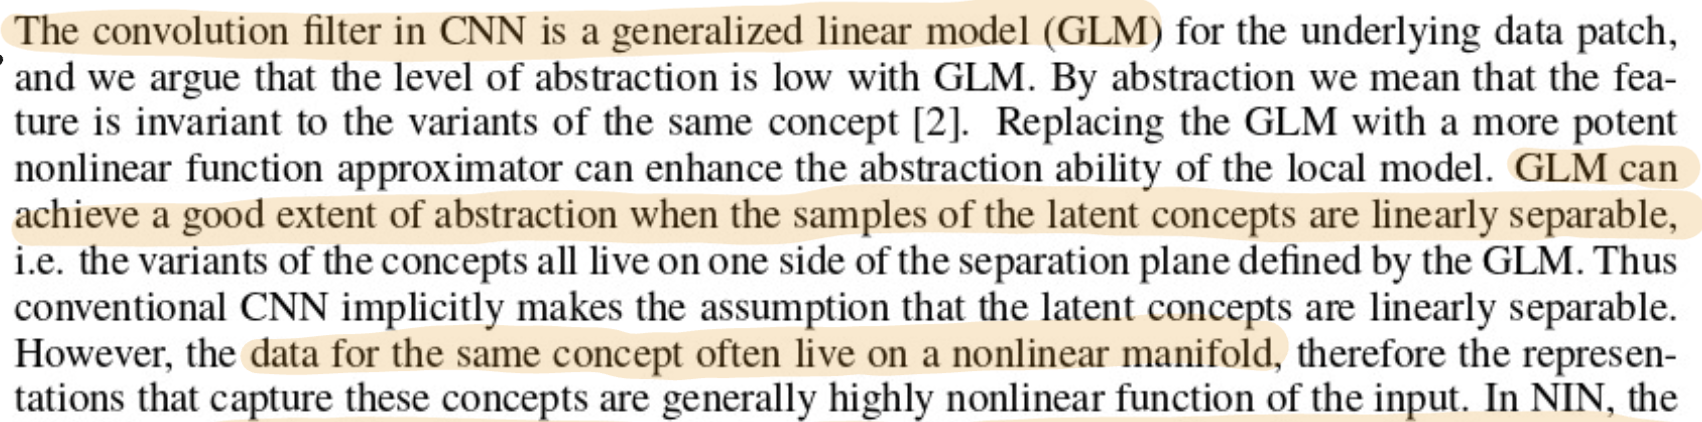

And researchers have found out solution: what if we replace GLM with Multilayer perceptron - general non-linear fucntion approximator?

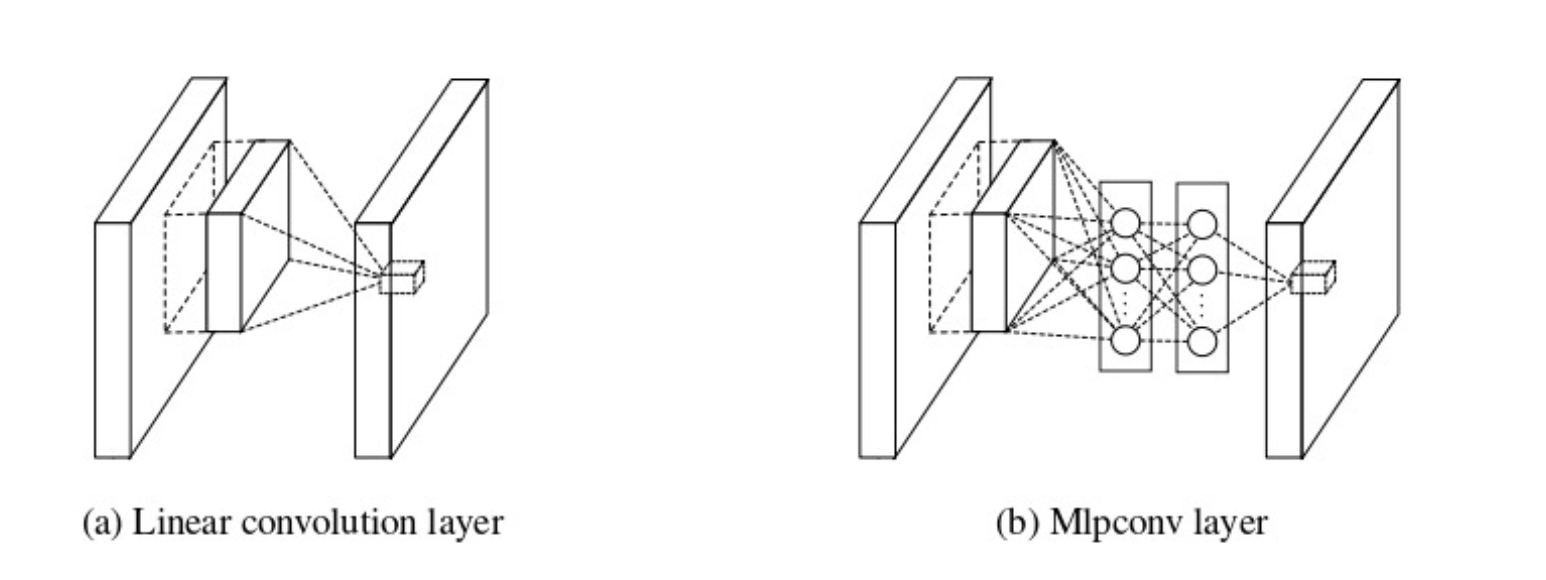

In the picture above we see, that for some pixel in feature map, we not just compute convolution of selected input patch and filter - we pass it trough $n$ number of MLP to introduce non-linearity(between each layer we use some activation function like ReLU):
$$f_{i,j,k_1}^1 = \max({w_{k_1}^1}^T x_{i,j} + b_{k_1}, 0)$$
$$\vdots$$
$$f_{i,j,k_n}^n = \max({w_{k_n}^n}^T f_{i,j}^{n-1} + b_{k_n}, 0)$$
- $x_{i,j}$: This is the input patch at location $(i,j)$. In the first layer, the MLP "slides" over this local area of the input image to extract features.
- $f_{i,j}^{n-1}$: This is the result (feature map) of the previous MLP layer. Because the MLP is a deep model itself, each subsequent layer takes the abstract representations calculated by the layer immediately before it to build higher-level features.

Here we can see reasons why such technique was chosen:
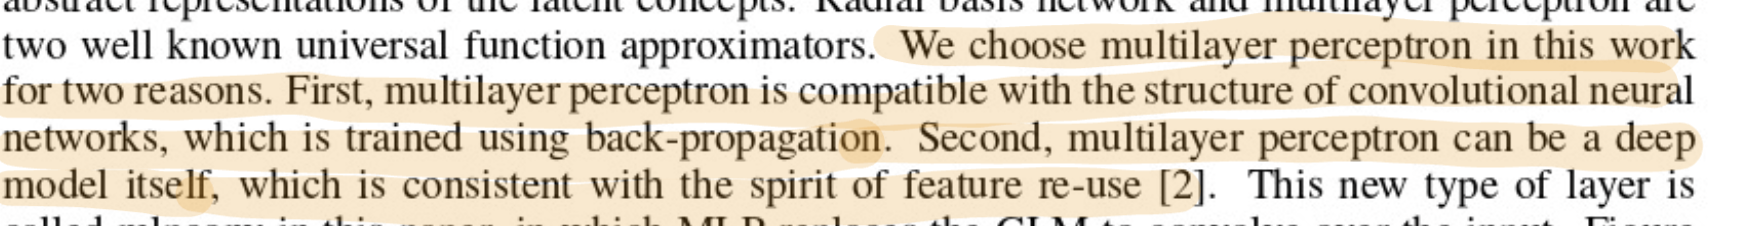

**2. Global average poooling**

We have used to the fact that, in general, CNN consists of two parts: feature extractor(Conventional layers) and clasifier(Fully-connected layers). But here, in this paper, traditional set of FC in the end was not used. Instead, reseachers have used the idea of Global Average Pooling. This thing force model to extract N feature maps after last NiN block, where N is the number of classes. Each of these blocks represent the confidence map of how model is confident that some image is related to some class. And to get N x 1 vector which which goes through Softmax - we just apply Average Pooling to each feature map with kernel size 1 x 1.

The main benifits of Global Average Pooling are:
- the feature maps can be easily interpreted as categories confidence maps
- no parameter to optimize in the global average pooling, since we do not use fully connected layers, so it reduces the chances of overfitting, because in traditional CNN, the biggest number of learnible params is located in the FC layers, and sometimes, witout using regularization techniques, such as Dropout, weight decay, Data Augmentation - they can provoke overfitting

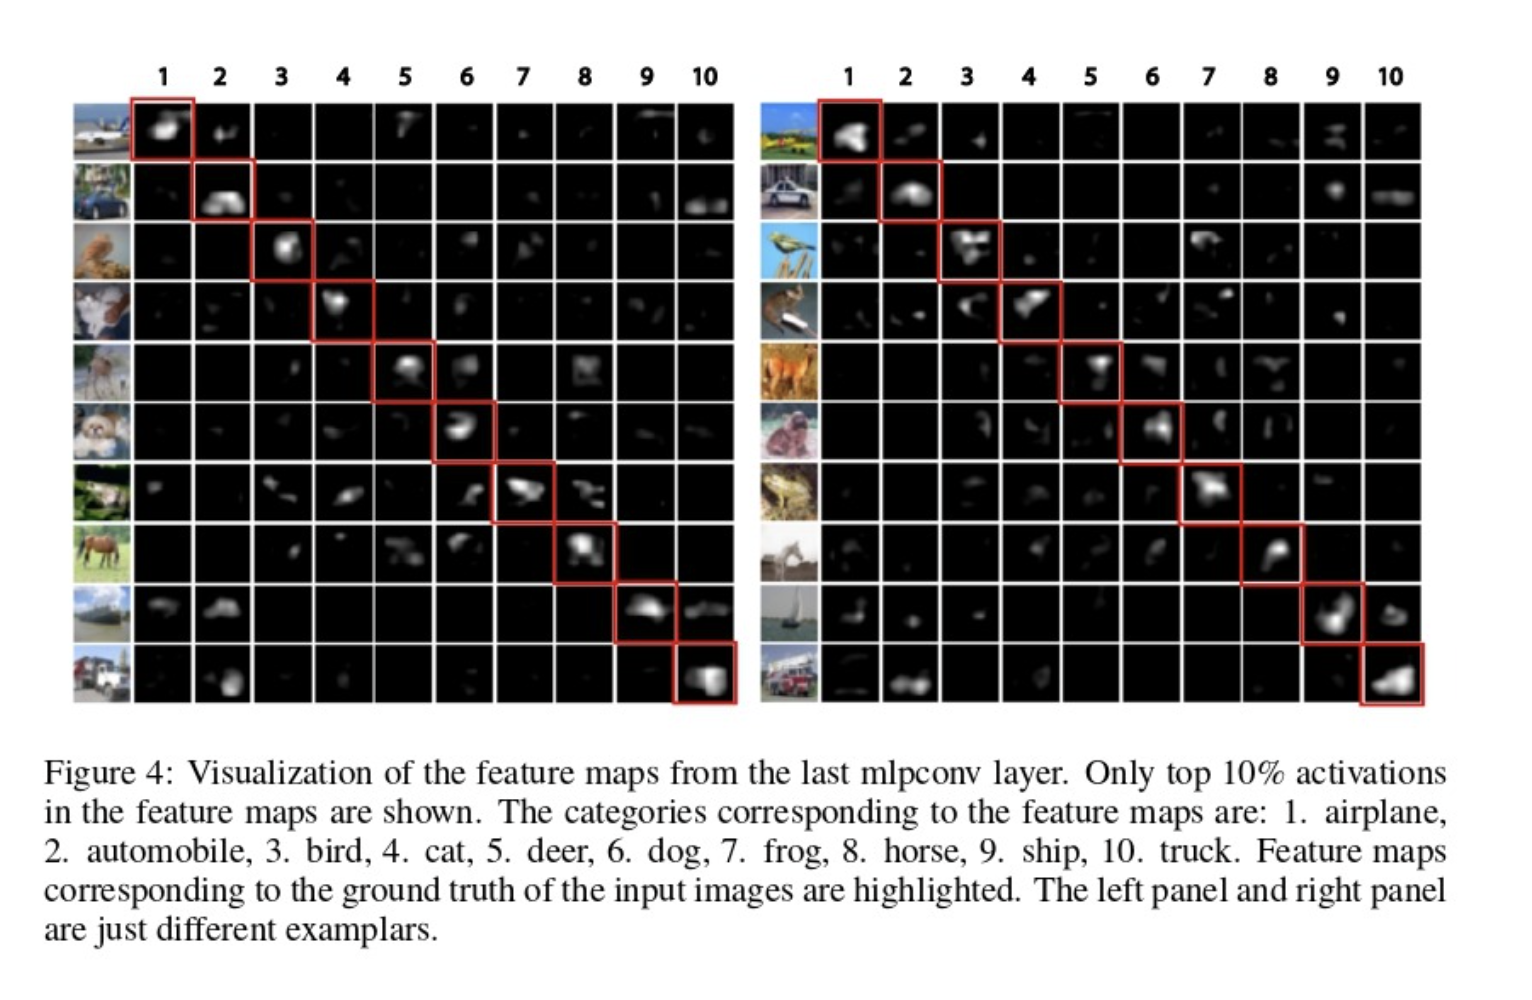

### Implementing NiN

In [1]:
import sys
import os

sys.path.append(os.path.abspath("../..")) 

from utils.utils import min_max_scaling, \
    set_random_seeds, plot_images, get_top_k_confident_mistakes, compute_FLOPS, \
    plot_top_mistakes, plot_training_results, plot_filters_and_feature_maps, count_params, get_gpu
from models.AlexNet import AlexNet
from models.VGG import VGG, get_vgg_features
from models.NiN import NiN, NiN_without_AGP
from engine.DatasetProvider import DatasetProvider, DatasetName
from engine.Trainer import Trainer
from models.AlexNet import AlexNet
import torchvision
from torchvision.transforms import transforms
import torch.nn.functional as F
import torch
from torch import nn
import torch.utils.data as data
from torchinfo import summary
import copy
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def NiN_block_example(in_channels, out_channels, n_MLP=2, kernel_size=(3, 3), stride=1, padding=0):
    block = [
        nn.Conv2d(
            in_channels=in_channels,
            out_channels=out_channels,
            stride=stride,
            kernel_size=kernel_size,
            padding=padding
        ),
        nn.ReLU(inplace=True)
    ]

    for _ in range(n_MLP):
        block.extend([
            nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=(1, 1)),
            nn.ReLU(inplace=True)
        ])
    
    return block


class NiN_example(nn.Module):
    def __init__(self, in_channels, out_features):
        super().__init__()

        self.features = nn.Sequential(
            *NiN_block_example(in_channels=in_channels, out_channels=96, n_MLP=2, kernel_size=(11, 11), stride=4),
            nn.MaxPool2d(kernel_size=(3, 3), stride=2),
            nn.Dropout(p=0.5),
            *NiN_block_example(in_channels=96, out_channels=256, n_MLP=2, kernel_size=(5, 5), padding=2),
            nn.MaxPool2d(kernel_size=(3, 3), stride=2),
            nn.Dropout(p=0.5),
            *NiN_block_example(in_channels=256, out_channels=384, n_MLP=2, kernel_size=(3, 3), padding=1),
            nn.MaxPool2d(kernel_size=(3, 3), stride=2),
            *NiN_block_example(in_channels=384, out_channels=out_features, n_MLP=2, kernel_size=(3, 3), padding=1),
        )

        self.global_avg_pool = nn.Sequential(
            nn.AdaptiveAvgPool2d(output_size=(1, 1)),
            nn.Flatten()
        )
    
    def forward(self, X):
        features = self.features(X)
        outputs = self.global_avg_pool(features)

        return outputs, features

In [3]:
model = NiN(in_channels=3, out_features=10)

model

NiN(
  (features): Sequential(
    (0): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4))
    (1): ReLU(inplace=True)
    (2): Conv2d(96, 96, kernel_size=(1, 1), stride=(1, 1))
    (3): ReLU(inplace=True)
    (4): Conv2d(96, 96, kernel_size=(1, 1), stride=(1, 1))
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=(3, 3), stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.5, inplace=False)
    (8): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (13): ReLU(inplace=True)
    (14): MaxPool2d(kernel_size=(3, 3), stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Dropout(p=0.5, inplace=False)
    (16): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (17): ReLU(inplace=True)
    (18): Conv2d(384, 384, kernel_size=(1, 1), stride=(1

Let's compute some interesting statistics of NiN, and compare with AlexNet and VGG

In [4]:
batch_size = 256
nin_stats = summary(model, input_size=(batch_size, 3, 227, 227))
print(nin_stats)

Layer (type:depth-idx)                   Output Shape              Param #
NiN                                      [256, 10]                 --
├─Sequential: 1-1                        [256, 10, 6, 6]           --
│    └─Conv2d: 2-1                       [256, 96, 55, 55]         34,944
│    └─ReLU: 2-2                         [256, 96, 55, 55]         --
│    └─Conv2d: 2-3                       [256, 96, 55, 55]         9,312
│    └─ReLU: 2-4                         [256, 96, 55, 55]         --
│    └─Conv2d: 2-5                       [256, 96, 55, 55]         9,312
│    └─ReLU: 2-6                         [256, 96, 55, 55]         --
│    └─MaxPool2d: 2-7                    [256, 96, 27, 27]         --
│    └─Dropout: 2-8                      [256, 96, 27, 27]         --
│    └─Conv2d: 2-9                       [256, 256, 27, 27]        614,656
│    └─ReLU: 2-10                        [256, 256, 27, 27]        --
│    └─Conv2d: 2-11                      [256, 256, 27, 27]        65,

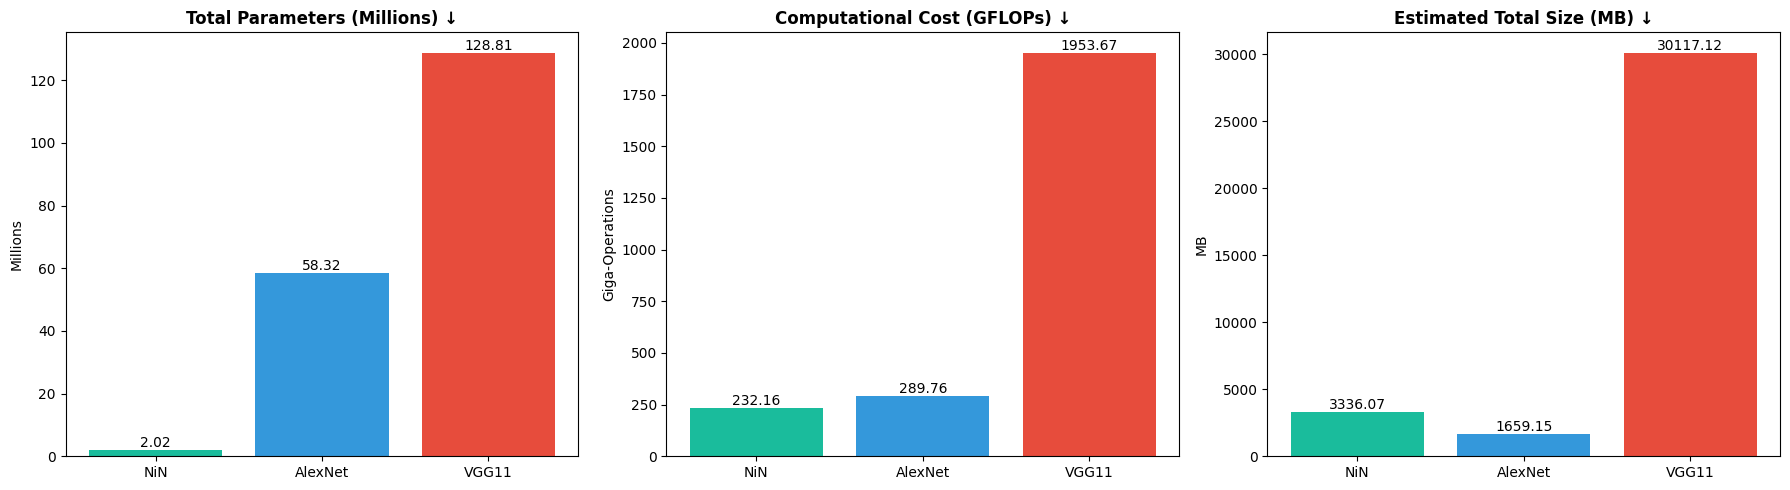

In [5]:
vgg11_config = [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M']

vgg = VGG(in_channels=3, out_features=10, config=vgg11_config)
alex_net = AlexNet(in_channels=3, out_features=10)

vgg_stats = summary(vgg, input_size=(batch_size, 3, 227, 227))
alex_net_stats = summary(alex_net, input_size=(batch_size, 3, 227, 227))

stats_list = [nin_stats, alex_net_stats, vgg_stats]
model_names = ['NiN', 'AlexNet', 'VGG11']
colors = ['#1abc9c', '#3498db', '#e74c3c']

params = [s.total_params / 1e6 for s in stats_list]
flops = [s.total_mult_adds / 1e9 for s in stats_list]

memory = []
for s in stats_list:
    total_bytes = s.total_input + s.total_output_bytes + s.total_param_bytes
    memory.append(total_bytes / (1024**2)) 

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
metrics = [params, flops, memory]
titles = ['Total Parameters (Millions) ↓', 
          'Computational Cost (GFLOPs) ↓', 
          'Estimated Total Size (MB) ↓']
y_labels = ['Millions', 'Giga-Operations', 'MB']

for i in range(3):
    bars = axes[i].bar(model_names, metrics[i], color=colors)
    axes[i].set_title(titles[i], fontweight='bold')
    axes[i].set_ylabel(y_labels[i])
    
    for bar in bars:
        height = bar.get_height()
        axes[i].text(bar.get_x() + bar.get_width()/2., height,
                     f'{height:.2f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

From images above we see interesting stats:
- NiN has extremely small number of params comparing to other two models
- Computational cost for NiN is almost the same as for AlexNet, while size - bigger. Despite AlexNet is "params heavy", NiN is "activations heavy", since it is deeper and contain more layers, so model must to keep more values for backward pass.
- VGG is such an enormous model, and i am not surprised that my laptop has not enjoyed the traning of it.

### Load data

As always, we will be using CIFAR10 dataset for tranining and comparing models

In [6]:
set_random_seeds(42)

In [7]:
dataset = DatasetProvider(
    dataset_name=DatasetName.CIFAR,
    batch_size=128,
    resize=259,
    random_rotation_degrees=5,
    random_hor_flip_probability=0.5,
    random_crop_size=227
)

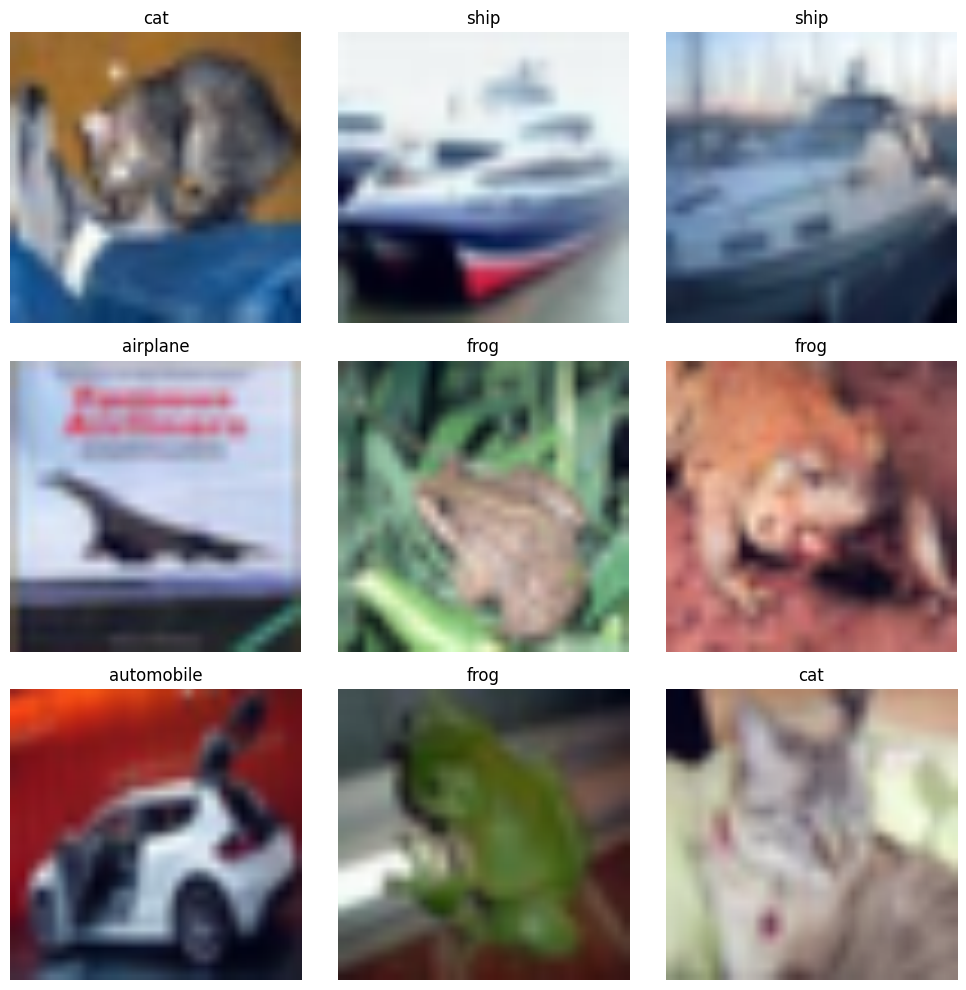

In [8]:
images, labels = next(iter(dataset.testloader))
classes = dataset.classes

plot_images(images[:9], labels[:9], classes, normalize=True)

### Training

For training i will be using Google Colab.

In [18]:
results = torch.load("./saved/NiN_(M=2)_stats.pth")

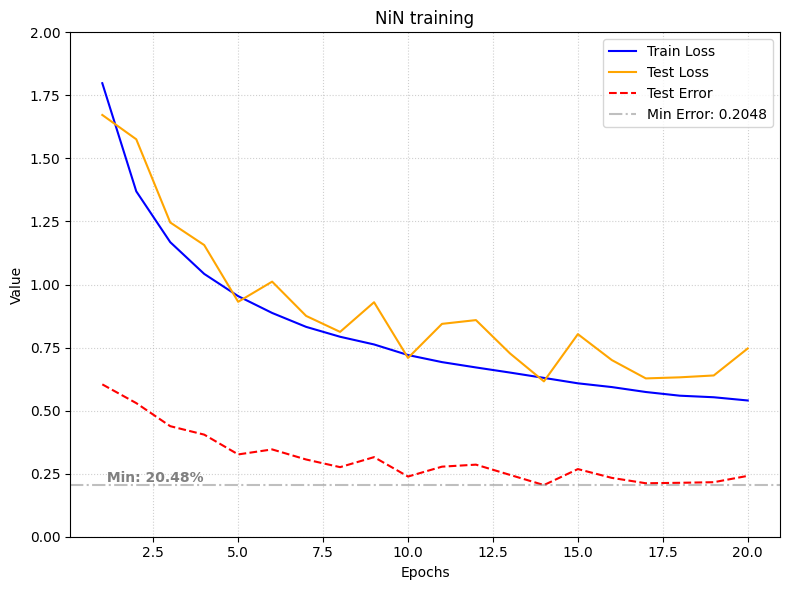

In [19]:
plot_training_results(results, titles=["NiN training"])

The model showed itselt quite well, maybe with smaller learning rate results will be better because we see that test loss is not smooth as train.